# Import data methods:
1. Reading zero-crossing file and extract time, frequency, amplitude and metadata information.(preferred)

In [1]:
import matplotlib.pyplot as plt
import numpy
from util.anabat import *
import random
import os

In [2]:
# Call extract_anabat from util.anabat to extract time, frequency, amplitude and partial metadata from zero-crossing file
info=extract_anabat('../data/P7132033.37# ')  # P7132035.14#  P7132033.37# 

In [3]:
t=info[0]
freq=info[1]
ampl=info[2]
metadata=info[3]

In [7]:
metadata

{'date': '        ',
 'divratio': 8,
 'gps': '',
 'id': '',
 'loc': '',
 'note1': 'V4062g',
 'note2': '',
 'spec': 'SD1 Mod1',
 'species': ['PERSUB '],
 'timestamp': datetime.datetime(2015, 7, 13, 20, 33, 37, 290175)}

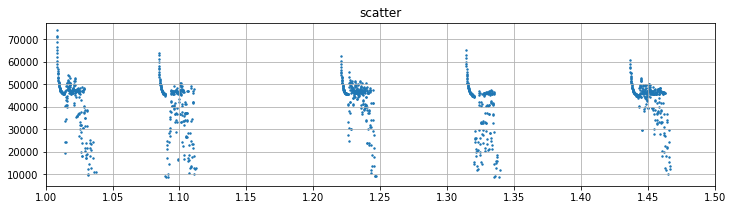

In [9]:
#visualization
plt.figure(figsize=(12,3))
plt.scatter(t, freq, s=2)
plt.xticks(numpy.arange(1, 1.6, 0.05))
plt.xlim(1, 1.5)
plt.title("scatter")
plt.grid()

2.Read from .csv files of time and freq that decoded using R.

In [7]:
# Read time and frequency data from a csv sample data file. 
# The data in csv file is processed using R from Bat acoustic recording (zero-crossing file) encoded by Anabat file format 132.(AnabatTools.R--see R codes for details)
import csv

call_list = list(csv.reader(open('../data/P7132033_37.csv', 'rb')))[1:]
#print call_list

# Remove noise and extract valid pulse signals 

1. Call remove_noise function from util.anabat to remove the noises of original zc file.
2. Get the returned valid pulses.
3. Use display_pulses method from util.anabat to plot a few random sample of the valid pulses.

In [4]:
# remove noise 
pulses=remove_noise(t,freq)

In [5]:
# length of pulses in a given zc file
num = len(pulses)
num 

23

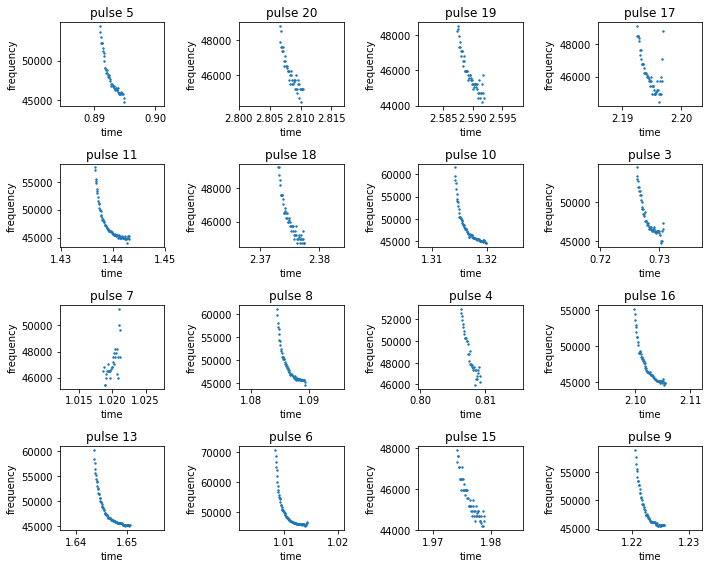

In [6]:
# plot random pulses sample
display_pulses(pulses, nrows=4, ncols=4, figsize=(10,8))